# Importing Libraries

In [1]:
import os
import sys
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectPercentile, f_classif, chi2


import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Pathing & Static variable

In [2]:
CURRENT_DIR = os.getcwd()
PROJECT_DIR = os.path.dirname(CURRENT_DIR)
MODELS_PATH = os.path.join(PROJECT_DIR, 'models')
ENCODER_PATH = os.path.join(MODELS_PATH, 'encoders')
LOGS_PATH = os.path.join(MODELS_PATH, 'logs')
LOG_CURRENT = os.path.join(LOGS_PATH, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
TEST_DATA_PATH = os.path.join(PROJECT_DIR, 
                              'data', 'raw', 'carInsurance_train.csv')

CATEG_PATH = os.path.join(PROJECT_DIR, 'references', 'categorical_columns.txt')
CONTI_PATH = os.path.join(PROJECT_DIR, 'references', 'continous_columns.txt')

PROJECT_NAME = '2.1-ie-Linear-SVC-model'
MODEL_NAME = 'LinearSVC-v1.0'

In [3]:
# adding system path
sys.path.insert(0, PROJECT_DIR)

In [4]:
# import internal function
from src.data import process_pipeline, encoder_pipeline, feature_selection_pipeline

# Helper Function

In [5]:
def get_content(txt_file):
    contents = []
    with open(txt_file) as file:
        for line in file:
            contents.append(line.strip())
            
    return contents

# Function to save a trained model
def save_model(model, model_name, folderPath):
    filename = os.path.join(folderPath, f"{model_name}_model.pkl")
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Function to load a saved model
def load_model(model_name):
    filename = f"{model_name}_model.pkl"
    if os.path.exists(filename):
        with open(filename, 'rb') as file:
            return pickle.load(file)
    else:
        return None

# Function to evaluate a model
def evaluate_model(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)

    # DL model return float type
    if y_pred.dtype != 'int':
        y_pred = y_pred.astype('int')
        
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}")
    return accuracy

# call backs
def callbacks(LOGS_PATH, patience):
    tensorboard_callbacks = TensorBoard(log_dir=LOGS_PATH, histogram_freq=1)
    early_callback = EarlyStopping(monitor='accuracy', patience=patience)
    return [early_callback, tensorboard_callbacks]

# Data Loading

In [6]:
df = pd.read_csv(TEST_DATA_PATH)
df = process_pipeline.process_data(df)
df.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,...,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance,HasCommuncation,CallDuration,CallCategory,DaysPassed_Simplify,Outcome_Simplify
0,1,32,management,single,tertiary,0,1218,1,0,telephone,...,0,failure,49520,49590,0,1,70.0,Afternoon,0,0
1,2,32,blue-collar,married,primary,0,1156,1,0,No Communication,...,0,failure,53343,53528,0,0,185.0,Afternoon,0,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,...,1,failure,59424,59764,1,1,340.0,Afternoon,0,0
3,4,25,student,single,primary,0,373,1,0,cellular,...,0,failure,43603,44422,1,1,819.0,Afternoon,0,0
4,5,30,management,married,tertiary,0,2694,0,0,cellular,...,0,failure,52544,52736,0,1,192.0,Afternoon,0,0


In [7]:
# Get list of categorical & continous variable
categ = get_content(CATEG_PATH)
conti = get_content(CONTI_PATH)

In [8]:
# making sure there's no target
categ

['Age',
 'Job',
 'Marital',
 'Education',
 'Default',
 'HHInsurance',
 'CarLoan',
 'Communication',
 'HasCommuncation',
 'LastContactDay',
 'LastContactMonth',
 'NoOfContacts',
 'PrevAttempts',
 'Outcome',
 'Outcome_Simplify',
 'CallCategory']

In [9]:
# label
X = df.drop(columns=['CarInsurance'])

#target
y = df['CarInsurance']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
df

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,...,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance,HasCommuncation,CallDuration,CallCategory,DaysPassed_Simplify,Outcome_Simplify
0,1,32,management,single,tertiary,0,1218,1,0,telephone,...,0,failure,49520,49590,0,1,70.0,Afternoon,0,0
1,2,32,blue-collar,married,primary,0,1156,1,0,No Communication,...,0,failure,53343,53528,0,0,185.0,Afternoon,0,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,...,1,failure,59424,59764,1,1,340.0,Afternoon,0,0
3,4,25,student,single,primary,0,373,1,0,cellular,...,0,failure,43603,44422,1,1,819.0,Afternoon,0,0
4,5,30,management,married,tertiary,0,2694,0,0,cellular,...,0,failure,52544,52736,0,1,192.0,Afternoon,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,28,technician,single,tertiary,0,0,1,0,cellular,...,2,failure,63988,64257,1,1,269.0,Afternoon,0,0
3996,3997,49,admin.,divorced,secondary,0,124,1,1,cellular,...,0,failure,53356,53481,0,1,125.0,Afternoon,0,0
3997,3998,27,admin.,single,secondary,0,-400,0,1,cellular,...,0,failure,44343,44633,0,1,290.0,Afternoon,0,0
3998,3999,36,entrepreneur,single,tertiary,0,658,1,0,cellular,...,3,failure,41255,41354,0,1,99.0,Morning,0,0


# Data Preprocessing

In [11]:
# Numeric feature processing
numeric_transformer = make_pipeline(
    # scaling
    StandardScaler()
)

# Categorical feature processing
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
categorical_transformer = make_pipeline(
    ordinal_encoder,
    StandardScaler()
)

# combine pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, conti),
        ("cat", categorical_transformer, categ)
    ]
)

In [12]:
# transform to get the shape
scaler_process = make_pipeline(preprocessor)
x_train = scaler_process.fit_transform(X_train)
x_test = scaler_process.transform(X_test)

# create a input and output shape
input_shape = np.shape(x_train)[1:]
model_output = 1 # len(np.unique(y_train, axis=0)) # alternative len(df.target.unique)

In [73]:
# manual testing
model = Sequential()
model.add(Input(shape=input_shape))

# idea 1: increase neuron till accuracy hit 80 then increase the layer to 90 for 50 epochs

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(model_output, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(
    x_train, y_train,
    verbose=0,
    epochs=50,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)]
)

In [74]:
evaluate_model(model, 'manual_keras', x_test, y_test)

25/25 [==============================] - 0s 3ms/step
manual_keras - Test Accuracy: 0.8150


0.815

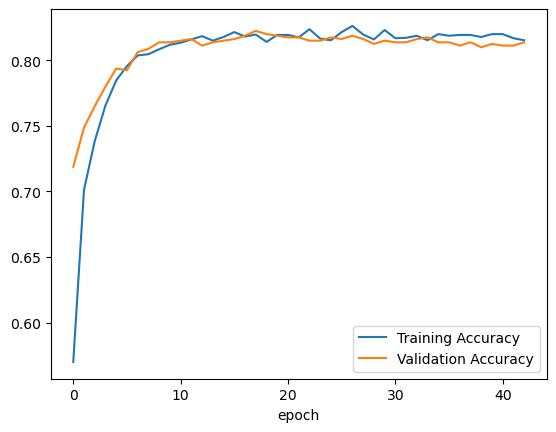

In [75]:
plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [16]:
# def create_model(input_shape, model_output):
#     model = Sequential()
#     # input layer
#     model.add(Input(shape=input_shape))

    
#     # layer 1
#     model.add(Dense(256, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))
#     # layer 2
#     model.add(Dense(512, activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.5))

#     # output
#     model.add(Dense(model_output, activation='sigmoid'))
#     model.compile(optimizer='adam', 
#                   loss='binary_crossentropy', 
#                   metrics=['accuracy']
#                  )
#     return model

In [17]:
# callbacks
early_callback, tensorboard_callbacks = callbacks(LOGS_PATH, patience=100)

In [18]:
clf = KerasClassifier(
    build_fn=create_model,
    callbacks=[early_callback, tensorboard_callbacks],
    verbose=0
)

NameError: name 'create_model' is not defined

In [ ]:
clf.get_params

In [ ]:
pipeline = make_pipeline(
    preprocessor,
    clf
)

In [ ]:
# model training
pipeline.fit(X_train, y_train)

In [ ]:
evaluate_model(pipeline, 'keras', X_test, y_test)

In [ ]:
# try:
#     scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
#     print(f"Sequential DL: Accuracy - {scores.mean():.4f} (± {scores.std():.4f})")
    
# except Exception as e:
#     print(f"Sequential DL: Fit failed with error: {e}")